# CNN electronic music label classification full-track chunk

### Import libraries

In [0]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils import data
import os
import tqdm as tqdm
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Class definition
Dataset and CNN

In [0]:
class AudioFolder(data.Dataset):
    def __init__(self, csv_path, labels):
        self.csv = pd.read_csv(csv_path)
        self.labels = labels        
        self.output_dict = dict()
        for i,l in enumerate(self.labels):
            self.output_dict[l]=i


    def __getitem__(self, index):
        npy, label = self.get_npy(index)
        return npy.astype('float'), label

    def get_npy(self, index):
        path = self.csv['path'][index]
        path = path.split('/homedtic/jbustos/mel_specs/')[1]
        path = '/content/drive/My Drive/archives/mel_specs/'+path
        npy = np.load(path)
        #Hot encoding output
        #label_hot = np.zeros(len(labels))
        label = self.output_dict[self.csv['label'][index]]
        #label_hot[label]=1
        return npy, label

    def __len__(self):
        return len(self.csv)


def my_collate(batch):

    min_size = min([item[0].shape[1] for item in batch]) 
    data = [item[0][:,:min_size] for item in batch]
    target = [item[1] for item in batch]
    data = torch.Tensor(data)
    target = torch.LongTensor(target)

    return [data, target]



def get_audio_loader():
    data_loader = data.DataLoader(dataset=AudioFolder(csv_path=csv_path, labels=labels),
                                  batch_size=batch_size,
                                  shuffle=True,
                                  collate_fn=my_collate,
                                  drop_last=False)
    return data_loader

In [0]:
class CNN(nn.Module):
    def __init__(self, gap_h, gap_w, num_class=9):
        super(CNN, self).__init__()

        # init bn
        self.bn_init = nn.BatchNorm2d(1)

        # layer 1
        self.conv_1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn_1 = nn.BatchNorm2d(64)
        self.mp_1 = nn.MaxPool2d((2, 4))

        # layer 2
        self.conv_2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn_2 = nn.BatchNorm2d(128)
        self.mp_2 = nn.MaxPool2d((2, 4))

        # layer 3
        self.conv_3 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn_3 = nn.BatchNorm2d(128)
        self.mp_3 = nn.MaxPool2d((2, 4))

        # layer 4
        self.conv_4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn_4 = nn.BatchNorm2d(128)
        self.mp_4 = nn.MaxPool2d((3, 5))

        # layer 5
        self.conv_5 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn_5 = nn.BatchNorm2d(64)
        self.mp_5 = nn.MaxPool2d((4, 4))

        # classifier
        self.dense = nn.Linear(64, num_class)

    def forward(self, x):
        x = x.unsqueeze(1)

        # init bn
        x = self.bn_init(x)
        # layer 1
        x = self.mp_1(nn.ELU()(self.bn_1(self.conv_1(x))))
        # layer 2
        x = self.mp_2(nn.ELU()(self.bn_2(self.conv_2(x))))
        # layer 3
        x = self.mp_3(nn.ELU()(self.bn_3(self.conv_3(x))))
        # layer 4
        x = self.mp_4(nn.ELU()(self.bn_4(self.conv_4(x))))
        # layer 5
        x = self.mp_5(nn.ELU()(self.bn_5(self.conv_5(x))))
        
        gap = nn.AvgPool2d((1, x.size(3)), stride=(1, 1))
        x = gap(x)
        # classifier
        x = x.view(x.size(0), -1)
        x = nn.Dropout(0.5)(x)
        logit = self.dense(x)

        return logit

Reading labels

In [6]:
count = 0
count_songs = 0
labels = []
labels_dict = dict()
main_dir = '/content/drive/My Drive/archives/mel_specs/complete_track/train'

for root, dirs, files in os.walk (main_dir):
    count += 1
    if count==1:
        labels = [label for label in dirs if not label.startswith('.')]
    else:
        break
print(labels)

for l in labels:
    count = 0
    for root, dirs, files in os.walk(main_dir+'/'+l):
        for file in files:
            count+=1
    print(l,' = ',count)

['defectedarchive', 'mordarchive', 'littlehelpersarchive', 'kompaktarchive', 'ninjatunearchive', 'stilvortalentarchive', 'chillhoparchive', 'suaraarchive', 'bar25archive']
defectedarchive  =  244
mordarchive  =  244
littlehelpersarchive  =  244
kompaktarchive  =  244
ninjatunearchive  =  244
stilvortalentarchive  =  244
chillhoparchive  =  244
suaraarchive  =  244
bar25archive  =  244


### Initialization dataset, model, criterion and optimizer

Train and set DataLoader initialization

In [0]:
csv_path = '/content/drive/My Drive/archives/mel_specs/complete_track/train_complete.csv'
batch_size = 4
train_loader = get_audio_loader()

csv_path = '/content/drive/My Drive/archives/mel_specs/complete_track/test_complete.csv'
batch_size = 4
test_loader = get_audio_loader()

Model, criterion and optimizer initialization

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
          nn.init.xavier_normal_(m.weight.data)       

In [9]:
torch.manual_seed(42)
device = torch.device('cuda')

model = CNN(num_class=9, gap_h=1, gap_w=2)
model.cuda(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 2e-4)
model.apply(weights_init)

CNN(
  (bn_init): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_1): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_2): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_3): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_4): BatchNorm2d(128, eps

Loading checkpoint

In [10]:
checkpoint = torch.load('/content/drive/My Drive/archives/mel_specs/complete_track/checkpointjbf.tar', map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
cost_list = checkpoint['cost_list']
model.cuda()

CNN(
  (bn_init): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_1): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_2): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_3): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_4): BatchNorm2d(128, eps

### Training

In [0]:
cost_list = []
#pred_list = []
epoch = 0
COST=0

In [0]:
for epoch in tqdm.tqdm(range(epoch,200)):
    COST=0
    model.train()
    for i,data in enumerate(train_loader):
        x,y = data
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()       
        y_=model(x)
        loss=criterion(y_,y)
        loss.backward()
        optimizer.step()
        COST+=loss.data
        
        if i % 50 == 0:
            print(loss)
    
    cost_list.append(COST)
    print('COST epoch',epoch, ' = ', cost_list)

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': COST,
            'cost_list': cost_list,
            }, '/content/drive/My Drive/archives/mel_specs/complete_track/checkpointjbf.tar')
    
    model.eval()
    y_list = []
    pred_list = []
    for i, data in enumerate(test_loader):
      x, y = data
      x = x.cuda()
      pred = model(x)

      # append
      pred = pred.detach().cpu()
      for _p in pred:
          pred_list.append(int(_p.argmax()))
      for _y in y:
          y_list.append(int(_y))

      if i % 10 == 0:
          print('Files processed = ', i)
          print(pred_list)
          print(y_list)

    accuracy = np.sum(np.asarray(pred_list)==np.asarray(y_list))/len(y_list)

    print('Accuracy epoch',epoch, ' = ',accuracy)

  0%|          | 0/170 [00:00<?, ?it/s]

tensor(0.9339, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2331, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0337, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6492, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3572, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.7971, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1332, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5612, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9746, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4057, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0106, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 30  =  [tensor(1111.4436), tensor(990.5597), tensor(934.4700), tensor(874.6571), tensor(822.8998), tensor(800.3447), tensor(765.9095), tensor(740.0458), tensor(718.9320), tensor(719.7072), tensor(693.2490), tensor(697.7689), tensor(672.8008), tensor(661.9917), tensor(658.5683), tensor(635.4274), tensor(631.2565), tensor(615.2205), tensor(

  1%|          | 1/170 [29:59<84:29:59, 1799.99s/it]

Accuracy epoch 30  =  0.5428051001821493
tensor(0.5435, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2193, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8449, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5524, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1673, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7680, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9643, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0292, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6537, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4501, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0145, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 31  =  [tensor(1111.4436), tensor(990.5597), tensor(934.4700), tensor(874.6571), tensor(822.8998), tensor(800.3447), tensor(765.9095), tensor(740.0458), tensor(718.9320), tensor(719.7072), tensor(693.2490), tensor(697.7689), tensor(672.8008), tensor(661.9917), tensor(658.5683), tensor(635.4274), te

  1%|          | 2/170 [55:27<80:11:02, 1718.23s/it]

Accuracy epoch 31  =  0.581056466302368
tensor(1.2521, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5582, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4263, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4973, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8706, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7377, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0175, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8473, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6141, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5321, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0479, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 32  =  [tensor(1111.4436), tensor(990.5597), tensor(934.4700), tensor(874.6571), tensor(822.8998), tensor(800.3447), tensor(765.9095), tensor(740.0458), tensor(718.9320), tensor(719.7072), tensor(693.2490), tensor(697.7689), tensor(672.8008), tensor(661.9917), tensor(658.5683), tensor(635.4274), ten

  2%|▏         | 3/170 [1:20:35<76:46:37, 1655.08s/it]

Accuracy epoch 32  =  0.5428051001821493
tensor(1.5031, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4138, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7908, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4838, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6377, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5801, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4263, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6724, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9516, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3752, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2529, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 33  =  [tensor(1111.4436), tensor(990.5597), tensor(934.4700), tensor(874.6571), tensor(822.8998), tensor(800.3447), tensor(765.9095), tensor(740.0458), tensor(718.9320), tensor(719.7072), tensor(693.2490), tensor(697.7689), tensor(672.8008), tensor(661.9917), tensor(658.5683), tensor(635.4274), te

  2%|▏         | 4/170 [1:45:43<74:17:35, 1611.18s/it]

Accuracy epoch 33  =  0.5245901639344263
tensor(0.6546, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2426, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5423, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3975, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2992, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4312, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7370, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8744, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9468, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4291, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2981, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 34  =  [tensor(1111.4436), tensor(990.5597), tensor(934.4700), tensor(874.6571), tensor(822.8998), tensor(800.3447), tensor(765.9095), tensor(740.0458), tensor(718.9320), tensor(719.7072), tensor(693.2490), tensor(697.7689), tensor(672.8008), tensor(661.9917), tensor(658.5683), tensor(635.4274), te

  3%|▎         | 5/170 [2:10:39<72:14:58, 1576.35s/it]

Accuracy epoch 34  =  0.5191256830601093
tensor(0.4560, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7780, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5180, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4236, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4209, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9785, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3215, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5189, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5953, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0266, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0908, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 35  =  [tensor(1111.4436), tensor(990.5597), tensor(934.4700), tensor(874.6571), tensor(822.8998), tensor(800.3447), tensor(765.9095), tensor(740.0458), tensor(718.9320), tensor(719.7072), tensor(693.2490), tensor(697.7689), tensor(672.8008), tensor(661.9917), tensor(658.5683), tensor(635.4274), te

  4%|▎         | 6/170 [2:35:45<70:51:27, 1555.41s/it]

Accuracy epoch 35  =  0.5792349726775956
tensor(0.5618, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0026, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3088, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4039, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.4932, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6446, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9798, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5103, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0938, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6084, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6826, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 36  =  [tensor(1111.4436), tensor(990.5597), tensor(934.4700), tensor(874.6571), tensor(822.8998), tensor(800.3447), tensor(765.9095), tensor(740.0458), tensor(718.9320), tensor(719.7072), tensor(693.2490), tensor(697.7689), tensor(672.8008), tensor(661.9917), tensor(658.5683), tensor(635.4274), te

  4%|▍         | 7/170 [3:01:09<70:00:12, 1546.09s/it]

Accuracy epoch 36  =  0.5719489981785064
tensor(0.4585, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9253, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5511, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3468, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5210, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2197, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4678, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8825, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7784, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0075, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5863, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 37  =  [tensor(1111.4436), tensor(990.5597), tensor(934.4700), tensor(874.6571), tensor(822.8998), tensor(800.3447), tensor(765.9095), tensor(740.0458), tensor(718.9320), tensor(719.7072), tensor(693.2490), tensor(697.7689), tensor(672.8008), tensor(661.9917), tensor(658.5683), tensor(635.4274), te

  5%|▍         | 8/170 [3:26:52<69:31:38, 1545.05s/it]

Accuracy epoch 37  =  0.5591985428051002
tensor(0.9269, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5650, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6376, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5012, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3192, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2530, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5717, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2310, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9401, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7808, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3659, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 38  =  [tensor(1111.4436), tensor(990.5597), tensor(934.4700), tensor(874.6571), tensor(822.8998), tensor(800.3447), tensor(765.9095), tensor(740.0458), tensor(718.9320), tensor(719.7072), tensor(693.2490), tensor(697.7689), tensor(672.8008), tensor(661.9917), tensor(658.5683), tensor(635.4274), te

  5%|▌         | 9/170 [3:52:18<68:50:47, 1539.42s/it]

Accuracy epoch 38  =  0.5428051001821493
tensor(1.0916, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9016, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3273, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0325, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6659, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7749, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8337, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5481, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3790, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0863, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 39  =  [tensor(1111.4436), tensor(990.5597), tensor(934.4700), tensor(874.6571), tensor(822.8998), tensor(800.3447), tensor(765.9095), tensor(740.0458), tensor(718.9320), tensor(719.7072), tensor(693.2490), tensor(697.7689), tensor(672.8008), tensor(661.9917), tensor(658.5683), tensor(635.4274), te

  6%|▌         | 10/170 [4:17:55<68:22:59, 1538.62s/it]

Accuracy epoch 39  =  0.5519125683060109
tensor(0.8459, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4638, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5338, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3811, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5335, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2403, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3082, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8749, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5516, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9750, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8493, device='cuda:0', grad_fn=<NllLossBackward>)
COST epoch 40  =  [tensor(1111.4436), tensor(990.5597), tensor(934.4700), tensor(874.6571), tensor(822.8998), tensor(800.3447), tensor(765.9095), tensor(740.0458), tensor(718.9320), tensor(719.7072), tensor(693.2490), tensor(697.7689), tensor(672.8008), tensor(661.9917), tensor(658.5683), tensor(635.4274), te

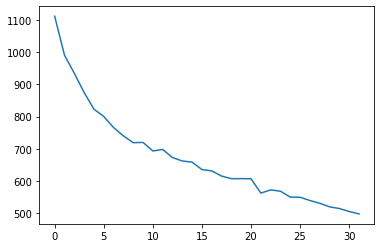

In [11]:
plt.plot(cost_list)

### Evaluation

Model loading

In [0]:
device = torch.device('cuda')
model = CNN(num_class=9, gap_h=1, gap_w=2)


checkpoint = torch.load('/content/drive/My Drive/complete_track/checkpoint>50.tar', map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
model.cuda()

CNN(
  (bn_init): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_1): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_2): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp_3): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_4): BatchNorm2d(128, eps

In [0]:
y_list = []
pred_list = []
model.eval()
for i, data in enumerate(test_loader):
    x, y = data
    x = x.cuda()
    pred = model(x)

    pred = pred.detach().cpu()
    for _p in pred:
          pred_list.append(int(_p.argmax()))
    for _y in y:
          y_list.append(int(_y))
        
    if i % 10 == 0:
        print('Files processed = ', i) 

Files processed =  0
Files processed =  10
Files processed =  20
Files processed =  30
Files processed =  40
Files processed =  50
Files processed =  60
Files processed =  70
Files processed =  80
Files processed =  90
Files processed =  100
Files processed =  110
Files processed =  120
Files processed =  130
Files processed =  140
Files processed =  150
Files processed =  160
Files processed =  170
Files processed =  180


Accuracy calculation

In [0]:
accuracy = np.sum(np.asarray(pred_list)==np.asarray(y_list))/len(y_list)
print(accuracy)

0.5610200364298725


Confusion matrix calculation

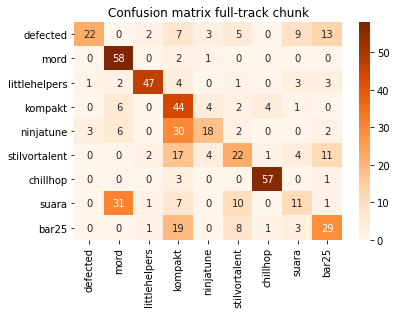

In [0]:
import sklearn.metrics
import seaborn
 
lab = [lab.split('archive')[0] for lab in labels]
plt.figure()
plt.title('Confusion matrix full-track chunk')
cm = sklearn.metrics.confusion_matrix(np.asarray(y_list), np.asarray(pred_list))
seaborn.heatmap(cm, annot=True, xticklabels=lab, yticklabels=lab, fmt="d", cmap = "Oranges")

F1 score calculation

In [0]:
sklearn.metrics.f1_score(y_list, pred_list, average='micro')

0.5596555646952932

# Further analysis

In this part we analyze train data set accuracy to check if model is overfitting

In [0]:
y_list = []
pred_list = []
model.eval()
for i, data in enumerate(train_loader):
    x, y = data
    x = x.cuda()
    pred = model(x)

    pred = pred.detach().cpu()
    for _p in pred:
          pred_list.append(int(_p.argmax()))
    for _y in y:
          y_list.append(int(_y))
        
    if i % 10 == 0:
        print('Files processed = ', i)

Files processed =  0
Files processed =  10
Files processed =  20
Files processed =  30
Files processed =  40
Files processed =  50
Files processed =  60
Files processed =  70
Files processed =  80
Files processed =  90
Files processed =  100
Files processed =  110
Files processed =  120
Files processed =  130
Files processed =  140
Files processed =  150
Files processed =  160
Files processed =  170
Files processed =  180
Files processed =  190
Files processed =  200
Files processed =  210
Files processed =  220
Files processed =  230
Files processed =  240
Files processed =  250
Files processed =  260
Files processed =  270
Files processed =  280
Files processed =  290
Files processed =  300
Files processed =  310
Files processed =  320
Files processed =  330
Files processed =  340
Files processed =  350
Files processed =  360
Files processed =  370
Files processed =  380
Files processed =  390
Files processed =  400
Files processed =  410
Files processed =  420
Files processed =  430

Accuracy calculation

In [0]:
accuracy = np.sum(np.asarray(pred_list)==np.asarray(y_list))/len(y_list)
print(accuracy)

0.9015945330296128


We see how the accuracy for training set is very high while test set accuracy is low. This shows that our model is overfitting